In [ ]:
!unzip -oq /kaggle/input/carvana-image-masking-challenge/train.zip
!unzip -oq /kaggle/input/carvana-image-masking-challenge/train_masks.zip
!unzip -oq /kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [95]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img


In [96]:
df = pd.read_csv('./train_masks.csv')
df.shape

(5088, 2)

In [97]:
val_size = 0.2
val_split = int(val_size * df.shape[0])

train_df = df[:-val_split]
val_df = df[-val_split:]

train_df.shape, val_df.shape

((4071, 2), (1017, 2))

In [98]:
train_df.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [99]:
img_name, mask_rle = train_df.iloc[0]

img = cv2.imread(f'./train/{img_name}')
mask = rle_decode(mask_rle)

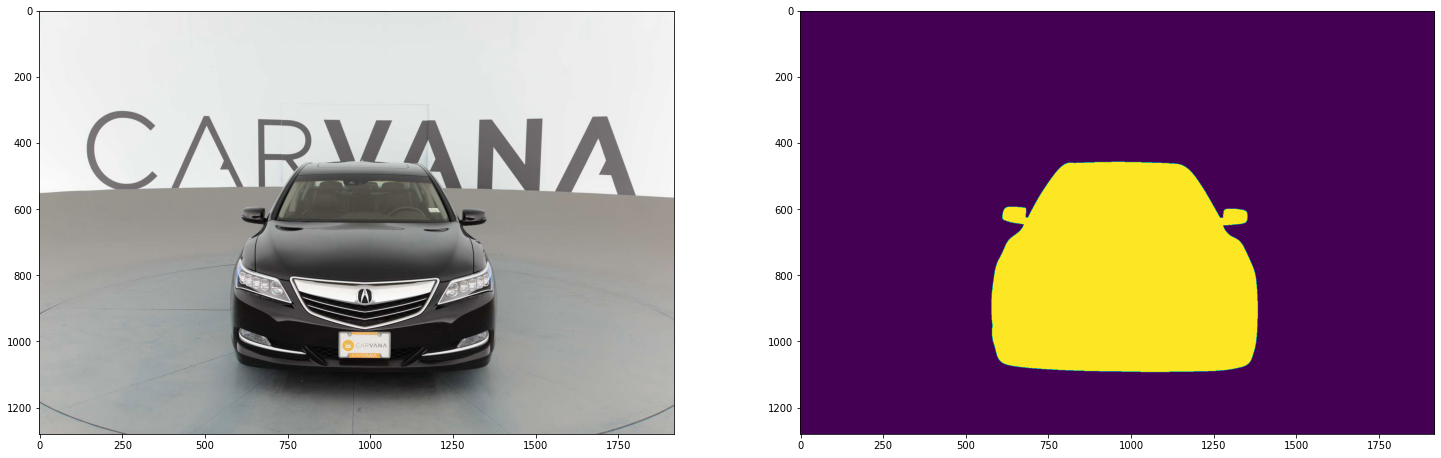

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(25, 25))
ax[0].imshow(img)
ax[1].imshow(mask)

plt.show()

In [101]:
train_df.sample(1)

,img,rle_mask
1114,34defeec3ce6_11.jpg,395703 18 397619 24 399535 28 401452 31 403370...


In [102]:
def keras_generator(df, batch_size, preprocess_input=None):
    while True:
        X_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = df.sample(1).values[0]
            img = cv2.imread(f'./train/{img_name}')
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            X_batch += [img]
            y_batch += [mask]

        if preprocess_input:
            X_batch = preprocess_input(np.array(X_batch))
        else:
            X_batch = np.array(X_batch) / 255.0
            
        y_batch = np.array(y_batch, dtype='float')

        yield X_batch, y_batch

In [103]:
for X, y in keras_generator(val_df, batch_size=32):
    print(X.shape, y.shape)
    break

(32, 256, 256, 3) (32, 256, 256)


## FCN
<img src='https://drive.google.com/uc?export=view&id=1j35v8z17TD6RgVTp2DoEokkCt44x71If' width=550>

In [104]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation


base_model = VGG16(weights='imagenet', input_shape=(256, 256, 3), include_top=False)
base_out = base_model.output
base_out

<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block5_pool')>

In [105]:
# up = UpSampling2D(32)(base_out)
up = UpSampling2D(32, interpolation='bilinear')(base_out)
up

<KerasTensor: shape=(None, 256, 256, 512) dtype=float32 (created by layer 'up_sampling2d_5')>

In [106]:
fcn = Model(inputs=base_model.input, outputs=up)
fcn.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0  

In [107]:
pred = fcn.predict(X)
# pred.shape

pred - карта с признаками (feature map), которая как-то характеризует картинку. 
Если посмотреть на любой канал у предсказания, то получим карту вероятностей.

Всё получилось пикселизировано, можно добавить линейную интерполяцию.

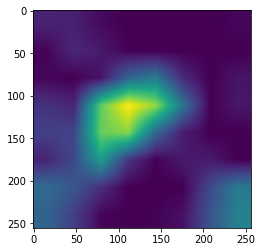

In [108]:
plt.imshow(pred[0, :, :, 0])

Теперь feature map нужно сжать до того количества каналов, сколько у нас классов для масок, в нашем случае с машинами есть только один ккалсс.

In [109]:
conv = Conv2D(1, (1, 1), activation='sigmoid')(up)  # (1, 1) потому что не надо изменять изображение, хочется только сжать каналы
conv

<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'conv2d_5')>

In [110]:
fcn = Model(inputs=base_model.input, outputs=conv)
fcn.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0  

In [111]:
pred = fcn.predict(X)
# pred.shape

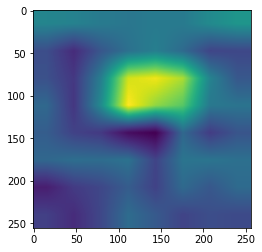

In [112]:
plt.imshow(pred[0])

In [113]:
checkpoint_best = keras.callbacks.ModelCheckpoint('fcn_best.h5',
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=True,
                                                  save_weights_only=False,
                                                  mode='auto',
                                                  period=1)

checkpoint_last = keras.callbacks.ModelCheckpoint('fcn_last.h5',
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=False,
                                                  save_weights_only=False,
                                                  mode='auto',
                                                  period=1)


callbacks = [checkpoint_best, checkpoint_last]



adam = keras.optimizers.Adam(lr=0.0001)

fcn.compile(adam, 'binary_crossentropy')

In [114]:
batch_size = 16

fcn.fit(keras_generator(train_df, batch_size), steps_per_epoch=100,
        epochs=2, verbose=1,
        callbacks=callbacks,
        validation_data=keras_generator(val_df, batch_size), validation_steps=50)

Epoch 1/2
100/100 [==============================] - 77s 764ms/step - loss: 0.1163 - val_loss: 0.0324
Epoch 2/2
100/100 [==============================] - 76s 762ms/step - loss: 0.0307 - val_loss: 0.0295


In [115]:
fcn.evaluate(keras_generator(val_df, batch_size), steps=25)

25/25 [==============================] - 11s 444ms/step - loss: 0.0293


0.029305297881364822

In [116]:
pred = fcn.predict(X)
pred.shape

(32, 256, 256, 1)

На выходе у нас будет не бинарная маска, а маска вероятностей.

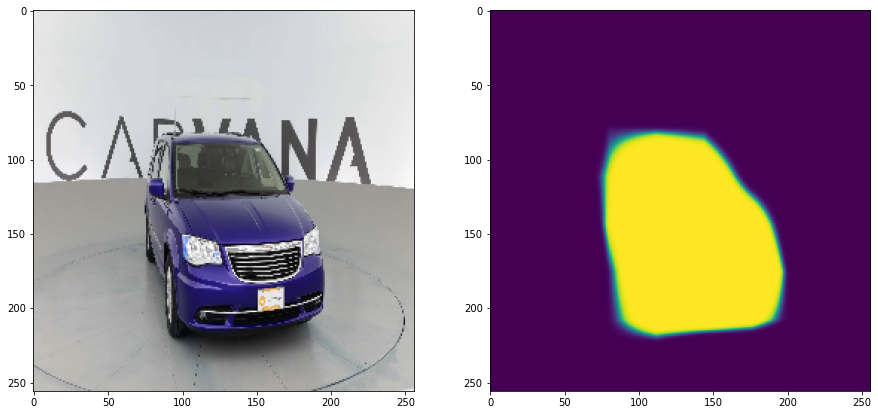

In [117]:
idx = 1
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(X[idx])
axes[1].imshow(pred[idx, ..., 0])

plt.show()

Чтобы перевести в бинарную маску, нужно сравнивать предсказанную вероятность с отсечкой.

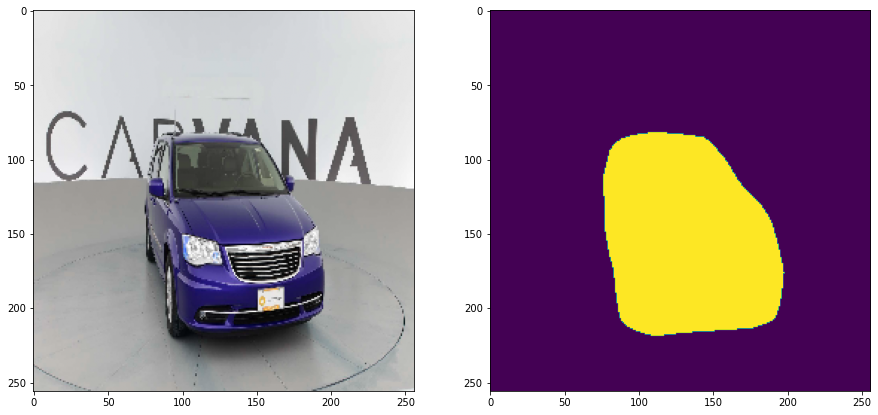

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(X[idx])
axes[1].imshow(pred[idx, ..., 0] > 0.5)

plt.show()

Большой недостаток рассмотренной архитектуры - слишком резко происходит увеличение изображения. Можно это смягчить за счет архитектуры SegNet.

## SegNet

<img src='https://drive.google.com/uc?export=view&id=1YRgQtgX90Y0YTuSRrDZfOr_qyEsVi6ax'>


In [119]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D


inp = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same', activation='relu')(inp)
conv_1_2 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv_1_1)

pool_1 = MaxPooling2D(2)(conv_1_2)


conv_2_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(pool_1)
conv_2_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv_2_1)

pool_2 = MaxPooling2D(2)(conv_2_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool_2)
conv_3_2 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv_3_1)

pool_3 = MaxPooling2D(2)(conv_3_2)


conv_4_1 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool_3)
conv_4_2 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv_4_1)

pool_4 = MaxPooling2D(2)(conv_4_2)
pool_4

<KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by layer 'max_pooling2d_3')>

In [120]:
up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)

conv_up_1_1 = Conv2D(256, (3, 3), padding='same', activation='relu')(up_1)
conv_up_1_2 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv_up_1_1)


up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)

conv_up_2_1 = Conv2D(128, (3, 3), padding='same', activation='relu')(up_2)
conv_up_2_2 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv_up_2_1)


up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)

conv_up_3_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(up_3)
conv_up_3_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv_up_3_1)


up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)

conv_up_4_1 = Conv2D(32, (3, 3), padding='same', activation='relu')(up_4)
conv_up_4_2 = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(conv_up_4_1)
conv_up_4_2

<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'conv2d_21')>

In [121]:
segnet = Model(inputs=inp, outputs=conv_up_4_2)
segnet.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0  

In [122]:
checkpoint_best = keras.callbacks.ModelCheckpoint('segnet_best.h5',
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=True,
                                                  save_weights_only=False,
                                                  mode='auto',
                                                  period=1)

checkpoint_last = keras.callbacks.ModelCheckpoint('segnet_last.h5',
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=False,
                                                  save_weights_only=False,
                                                  mode='auto',
                                                  period=1)


callbacks = [checkpoint_best, checkpoint_last]

adam = keras.optimizers.Adam(lr=0.0001)

segnet.compile(adam, 'binary_crossentropy')

In [123]:
batch_size = 16

segnet.fit(keras_generator(train_df, batch_size), steps_per_epoch=100,
           epochs=3, verbose=1,
           callbacks=callbacks,
           validation_data=keras_generator(val_df, batch_size), validation_steps=50)

Epoch 1/3
100/100 [==============================] - 71s 697ms/step - loss: 0.4702 - val_loss: 0.1987
Epoch 2/3
100/100 [==============================] - 68s 683ms/step - loss: 0.1289 - val_loss: 0.0732
Epoch 3/3
100/100 [==============================] - 68s 683ms/step - loss: 0.0700 - val_loss: 0.0574


In [124]:
segnet.evaluate(keras_generator(val_df, batch_size), steps=25)

25/25 [==============================] - 11s 448ms/step - loss: 0.0582


0.05822662264108658

In [125]:
pred = segnet.predict(X)
pred.shape

(32, 256, 256, 1)

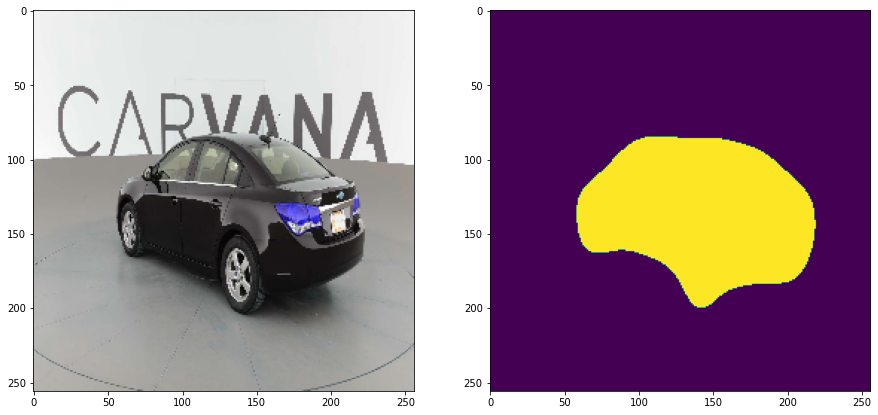

In [126]:
idx = 0
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(X[idx])
axes[1].imshow(pred[idx, ..., 0] > 0.5)

plt.show()

## U-net
<img src='https://drive.google.com/uc?Export=view&id=1B_SOnL99Qwc-Yrka0kK7V5dTH3mJQZwN'>

In [127]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

inp = Input(shape=(256, 256, 3))


# Downsampling
conv_1_1 = Conv2D(32, (3, 3), padding='same', activation='relu')(inp)
conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)

pool_1 = MaxPooling2D(2)(conv_1_2)


conv_2_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(pool_1)
conv_2_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv_2_1)

pool_2 = MaxPooling2D(2)(conv_2_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool_2)
conv_3_2 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv_3_1)

pool_3 = MaxPooling2D(2)(conv_3_2)


# Bottleneck
conv_4_1 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool_3)
conv_4_2 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv_4_1)

pool_4 = MaxPooling2D(2)(conv_4_2)
pool_4

<KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by layer 'max_pooling2d_7')>

In [128]:
# Upsampling
up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = Concatenate()([conv_4_2, up_1])

conv_up_1_1 = Conv2D(256, (3, 3), padding='same', activation='relu')(conc_1)
conv_up_1_2 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv_up_1_1)


up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_3_2, up_2])

conv_up_2_1 = Conv2D(128, (3, 3), padding='same', activation='relu')(conc_2)
conv_up_2_2 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv_up_2_1)


up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_2_2, up_3])

conv_up_3_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(conc_3)
conv_up_3_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv_up_3_1)


up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_1_2, up_4])

conv_up_4_1 = Conv2D(32, (3, 3), padding='same', activation='relu')(conc_4)
conv_up_4_2 = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(conv_up_4_1)
conv_up_4_2

<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'conv2d_37')>

In [129]:
unet = Model(inputs=inp, outputs=conv_up_4_2)
unet.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 256, 256, 32) 896         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_22[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_23[0][0]                  
___________________________________________________________________________________________

In [130]:
checkpoint_best = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=True,
                                                  save_weights_only=False,
                                                  mode='auto',
                                                  period=1)

checkpoint_last = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=False,
                                                  save_weights_only=False,
                                                  mode='auto',
                                                  period=1)


callbacks = [checkpoint_best, checkpoint_last]

adam = keras.optimizers.Adam(lr=0.0001)

unet.compile(adam, 'binary_crossentropy')

In [131]:
batch_size = 16

unet.fit(keras_generator(train_df, batch_size), steps_per_epoch=100,
         epochs=3, verbose=1,
         callbacks=callbacks,
         validation_data=keras_generator(val_df, batch_size), validation_steps=50)

Epoch 1/3
100/100 [==============================] - 71s 700ms/step - loss: 0.4677 - val_loss: 0.1240
Epoch 2/3
100/100 [==============================] - 69s 694ms/step - loss: 0.1007 - val_loss: 0.0613
Epoch 3/3
100/100 [==============================] - 69s 698ms/step - loss: 0.0657 - val_loss: 0.0496


In [132]:
unet.evaluate(keras_generator(val_df, batch_size), steps=25)

25/25 [==============================] - 10s 421ms/step - loss: 0.0521


0.05214332044124603

In [133]:
pred = unet.predict(X)
pred.shape

(32, 256, 256, 1)

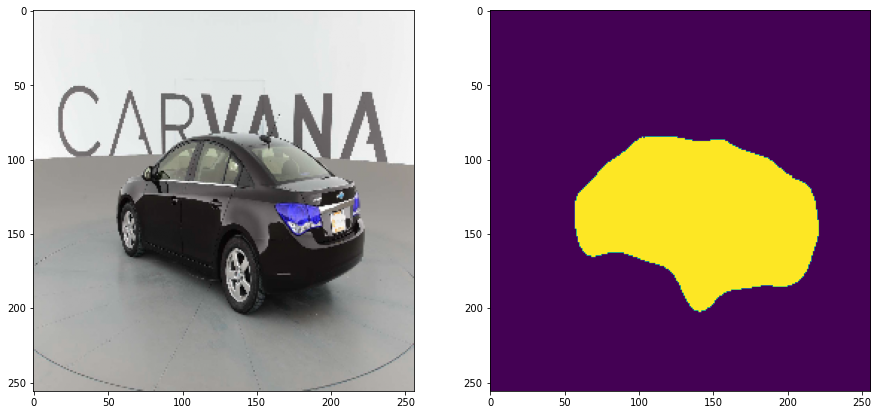

In [134]:
idx = 0
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(X[idx])
axes[1].imshow(pred[idx, ..., 0] > 0.5)

plt.show()

## U-net + ResNet50

<img src='https://drive.google.com/uc?export=view&id=1mAxaE49NHBSJp3wXzu-z_4LYcoRGYY0t'>

In [159]:
import keras
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras import backend as K


base_model = ResNet50(weights='imagenet', input_shape=(256, 256, 3), include_top=False)
 
base_out = base_model.output
base_out

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [160]:
# len(base_model.layers)

In [161]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [162]:
conv1 = base_model.get_layer('conv1_relu').output  # (128, 128, 64)
conv2 = base_model.get_layer('conv2_block1_out').output  # (64, 64, 256)
conv3 = base_model.get_layer('conv3_block1_1_relu').output  # (32, 32, 128)
conv4 = base_model.get_layer('conv4_block2_2_relu').output  # (16, 16, 256)
conv5 = base_model.get_layer('conv5_block1_2_relu').output  # (8, 8, 512)


inp = base_model.get_layer('input_9').output

ValueError: No such layer: input_9.

In [140]:
conv5

<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'conv5_block1_2_relu')>

In [141]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
print(conc_1)
conv_conc_1 = Conv2D(256, (3, 3), padding='same', activation='relu')(conc_1)

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 768), dtype=tf.float32, name=None), name='concatenate_4/concat:0', description="created by layer 'concatenate_4'")


In [142]:
up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3, 3), padding='same', activation='relu')(conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3, 3), padding='same', activation='relu')(conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3, 3), padding='same', activation='relu')(conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(up5)

In [143]:
unet_50 = Model(inputs=base_model.input, outputs=conv_conc_5)
unet_50.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [144]:
checkpoint_best = keras.callbacks.ModelCheckpoint('unet_50_best.h5',
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=True,
                                                  save_weights_only=False,
                                                  mode='auto',
                                                  period=1)

checkpoint_last = keras.callbacks.ModelCheckpoint('unet_50_last.h5',
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=False,
                                                  save_weights_only=False,
                                                  mode='auto',
                                                  period=1)


callbacks = [checkpoint_best, checkpoint_last]

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

unet_50.compile(adam, 'binary_crossentropy')

In [145]:
batch_size = 16

unet_50.fit(keras_generator(train_df, batch_size, preprocess_input),
            steps_per_epoch=100,
            epochs=3, verbose=1,
            callbacks=callbacks,
            validation_data=keras_generator(val_df, batch_size, preprocess_input),
            validation_steps=10)

Epoch 1/3
100/100 [==============================] - 59s 532ms/step - loss: 0.1500 - val_loss: 0.0259
Epoch 2/3
100/100 [==============================] - 52s 529ms/step - loss: 0.0209 - val_loss: 0.0175
Epoch 3/3
100/100 [==============================] - 53s 531ms/step - loss: 0.0157 - val_loss: 0.0151


In [146]:
unet_50.evaluate(keras_generator(val_df, batch_size, preprocess_input), steps=25)

25/25 [==============================] - 11s 434ms/step - loss: 0.0150


0.015035055577754974

-123.68 151.061


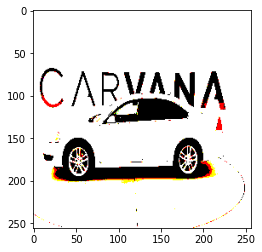

In [175]:
for X, y in keras_generator(val_df, 16, preprocess_input):
    plt.imshow(X[0])
    print(X[0].min(), X[0].max())
    break

In [176]:
pred = unet_50.predict(X)

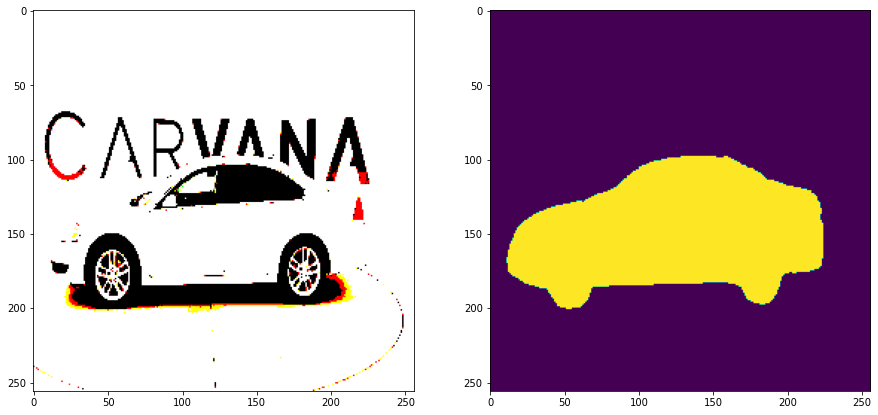

In [177]:
idx = 0
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(X[idx])
axes[1].imshow(pred[idx, ..., 0] > 0.5)

plt.show()

## Segmantational models

https://github.com/qubvel/segmentation_models

In [150]:
!pip install segmentation-models

     |████████████████████████████████| 50 kB 3.4 MB/s eta 0:00:011


In [151]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define model
model = sm.Unet(BACKBONE, classes=1, encoder_weights='imagenet')

model.compile(
    keras.optimizers.Adam(lr=0.001),
    loss='binary_crossentropy',
)

# fit model
model.fit(keras_generator(train_df, batch_size, preprocess_input),
          steps_per_epoch=100,
          epochs=3, verbose=1,
          callbacks=callbacks,
          validation_data=keras_generator(val_df, batch_size, preprocess_input),
          validation_steps=10)

Segmentation Models: using `tf.keras` framework.
85524480/85521592 [==============================] - 1s 0us/step: 
Epoch 1/3
100/100 [==============================] - 56s 513ms/step - loss: 0.1796 - val_loss: 0.3922
Epoch 2/3
100/100 [==============================] - 50s 504ms/step - loss: 0.0207 - val_loss: 0.0207
Epoch 3/3
100/100 [==============================] - 50s 505ms/step - loss: 0.0141 - val_loss: 0.0139


In [152]:
model.evaluate(keras_generator(val_df, batch_size, preprocess_input), steps=25)

25/25 [==============================] - 10s 417ms/step - loss: 0.0131


0.013067763298749924

0 255


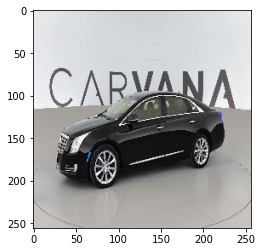

In [155]:
for X, y in keras_generator(val_df, 16, preprocess_input):
    plt.imshow(X[0])
    print(X[0].min(), X[0].max())
    break

In [156]:
pred = model.predict(X)

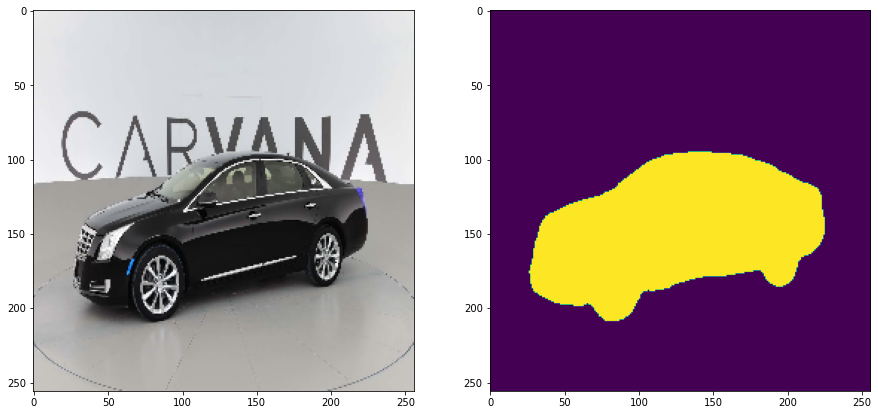

In [157]:
idx = 0
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(X[idx])
axes[1].imshow(pred[idx, ..., 0] > 0.5)

plt.show()